## 1. Customize model configuration

In [96]:
import torch
from torch import nn
from peft import LoraConfig, get_peft_model, PeftModel
import matplotlib.pyplot as plt

In [28]:
net = nn.Sequential(
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10,2)
)

In [29]:
net

Sequential(
  (0): Linear(in_features=10, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=2, bias=True)
)

In [30]:
type(net)

torch.nn.modules.container.Sequential

In [31]:
for name, param in net.named_parameters():
    print(name)

0.weight
0.bias
2.weight
2.bias


In [32]:
config = LoraConfig(target_modules = ["0"])

In [33]:
config

LoraConfig(task_type=None, peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, inference_mode=False, r=8, target_modules={'0'}, exclude_modules=None, lora_alpha=8, lora_dropout=0.0, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', trainable_token_indices=None, loftq_config={}, eva_config=None, corda_config=None, use_dora=False, use_qalora=False, qalora_group_size=16, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False), lora_bias=False, target_parameters=None)

In [34]:
model = get_peft_model(net, config)

In [35]:
model

PeftModel(
  (base_model): LoraModel(
    (model): Sequential(
      (0): lora.Linear(
        (base_layer): Linear(in_features=10, out_features=10, bias=True)
        (lora_dropout): ModuleDict(
          (default): Identity()
        )
        (lora_A): ModuleDict(
          (default): Linear(in_features=10, out_features=8, bias=False)
        )
        (lora_B): ModuleDict(
          (default): Linear(in_features=8, out_features=10, bias=False)
        )
        (lora_embedding_A): ParameterDict()
        (lora_embedding_B): ParameterDict()
        (lora_magnitude_vector): ModuleDict()
      )
      (1): ReLU()
      (2): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

In [36]:
model.print_trainable_parameters()

trainable params: 160 || all params: 292 || trainable%: 54.7945


## 2. Multi-adapter loading and switching

In [74]:
net = nn.Sequential(
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10,2)
)

In [75]:
config = LoraConfig(target_modules = ["0"])

In [76]:
config

LoraConfig(task_type=None, peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, inference_mode=False, r=8, target_modules={'0'}, exclude_modules=None, lora_alpha=8, lora_dropout=0.0, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', trainable_token_indices=None, loftq_config={}, eva_config=None, corda_config=None, use_dora=False, use_qalora=False, qalora_group_size=16, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False), lora_bias=False, target_parameters=None)

In [77]:
model = get_peft_model(net, config)

`get_peft_model` injects adapter layers (e.g., LoRA, IA³, Prompt Tuning) directly into the modules of the base model (net). This means:

- The original model object is mutated—not cloned.
- The adapter layers are added to the same Python object.
- Any reference to net after this call will reflect the modified state.

In [78]:
net

Sequential(
  (0): lora.Linear(
    (base_layer): Linear(in_features=10, out_features=10, bias=True)
    (lora_dropout): ModuleDict(
      (default): Identity()
    )
    (lora_A): ModuleDict(
      (default): Linear(in_features=10, out_features=8, bias=False)
    )
    (lora_B): ModuleDict(
      (default): Linear(in_features=8, out_features=10, bias=False)
    )
    (lora_embedding_A): ParameterDict()
    (lora_embedding_B): ParameterDict()
    (lora_magnitude_vector): ModuleDict()
  )
  (1): ReLU()
  (2): Linear(in_features=10, out_features=2, bias=True)
)

In [79]:
model

PeftModel(
  (base_model): LoraModel(
    (model): Sequential(
      (0): lora.Linear(
        (base_layer): Linear(in_features=10, out_features=10, bias=True)
        (lora_dropout): ModuleDict(
          (default): Identity()
        )
        (lora_A): ModuleDict(
          (default): Linear(in_features=10, out_features=8, bias=False)
        )
        (lora_B): ModuleDict(
          (default): Linear(in_features=8, out_features=10, bias=False)
        )
        (lora_embedding_A): ParameterDict()
        (lora_embedding_B): ParameterDict()
        (lora_magnitude_vector): ModuleDict()
      )
      (1): ReLU()
      (2): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

Assume we finished the training and we are going to save the model.

The configuration, not the full model will be saved in the newly created folder designated as an input parameter.

When you save a LoRA model using PEFT, you're typically saving:

- The LoRA configuration
- The LoRA adapter weights (i.e., the low-rank updates)
- Not the full pretrained model weights

So when you load it back, PEFT needs the original base model (net) to:
- Reconstruct the full model by injecting the LoRA layers into the correct places
- Ensure the adapter is applied to the correct architecture and modules (e.g., q_proj, v_proj)

In [62]:
model.save_pretrained("./LoRA1")

In [63]:
net2 = nn.Sequential(
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10,2)
)
net2

Sequential(
  (0): Linear(in_features=10, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=2, bias=True)
)

In [65]:
config2 = LoraConfig(target_modules = ["2"])
model2 = get_peft_model(net2, config2)

In [66]:
model2.save_pretrained("./LoRA2")

Load the saved model.

In [68]:
net = nn.Sequential(
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10,2)
)
net

Sequential(
  (0): Linear(in_features=10, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=2, bias=True)
)

In [69]:
model_loaded = PeftModel.from_pretrained(net, model_id = "./LoRA1", adapter_name = "LoRA1")

In [70]:
model_loaded

PeftModel(
  (base_model): LoraModel(
    (model): Sequential(
      (0): lora.Linear(
        (base_layer): Linear(in_features=10, out_features=10, bias=True)
        (lora_dropout): ModuleDict(
          (LoRA1): Identity()
        )
        (lora_A): ModuleDict(
          (LoRA1): Linear(in_features=10, out_features=8, bias=False)
        )
        (lora_B): ModuleDict(
          (LoRA1): Linear(in_features=8, out_features=10, bias=False)
        )
        (lora_embedding_A): ParameterDict()
        (lora_embedding_B): ParameterDict()
        (lora_magnitude_vector): ModuleDict()
      )
      (1): ReLU()
      (2): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

In [71]:
model

PeftModel(
  (base_model): LoraModel(
    (model): Sequential(
      (0): lora.Linear(
        (base_layer): Linear(in_features=10, out_features=10, bias=True)
        (lora_dropout): ModuleDict(
          (default): Identity()
        )
        (lora_A): ModuleDict(
          (default): Linear(in_features=10, out_features=8, bias=False)
        )
        (lora_B): ModuleDict(
          (default): Linear(in_features=8, out_features=10, bias=False)
        )
        (lora_embedding_A): ParameterDict()
        (lora_embedding_B): ParameterDict()
        (lora_magnitude_vector): ModuleDict()
      )
      (1): ReLU()
      (2): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

Use `load_adapter` to add adapterto existing model.

In [72]:
model_loaded.load_adapter("./LoRA2", adapter_name = "LoRA2")

<All keys matched successfully>

In [73]:
model_loaded

PeftModel(
  (base_model): LoraModel(
    (model): Sequential(
      (0): lora.Linear(
        (base_layer): Linear(in_features=10, out_features=10, bias=True)
        (lora_dropout): ModuleDict(
          (LoRA1): Identity()
        )
        (lora_A): ModuleDict(
          (LoRA1): Linear(in_features=10, out_features=8, bias=False)
        )
        (lora_B): ModuleDict(
          (LoRA1): Linear(in_features=8, out_features=10, bias=False)
        )
        (lora_embedding_A): ParameterDict()
        (lora_embedding_B): ParameterDict()
        (lora_magnitude_vector): ModuleDict()
      )
      (1): ReLU()
      (2): lora.Linear(
        (base_layer): Linear(in_features=10, out_features=2, bias=True)
        (lora_dropout): ModuleDict(
          (LoRA2): Identity()
        )
        (lora_A): ModuleDict(
          (LoRA2): Linear(in_features=10, out_features=8, bias=False)
        )
        (lora_B): ModuleDict(
          (LoRA2): Linear(in_features=8, out_features=2, bias=False)
   

In [80]:
model_loaded.active_adapter

'LoRA1'

At this time, model_loaded is loaded with LoRA1 and LoRA2, but it only show LoRA1 here.

In [83]:
model_loaded(torch.arange(0,10).view(1,10).float())

tensor([[ 2.2643, -2.1980]], grad_fn=<AddmmBackward0>)

The above result is the forward propagation with only LoRA1. But actually since LoRA1 is not trained, meaning LoRAB in LoRA1 is only zero, so the result will be the same as if there were no LoRA1. In short, LoRA1 doesn't have any impact to the result.

Observe all the parameters, especailly LoRA1.

In [85]:
for name, param in model_loaded.named_parameters():
    print(name, param)

base_model.model.0.base_layer.weight Parameter containing:
tensor([[ 0.2148,  0.2300, -0.0852, -0.0385,  0.1528, -0.2517,  0.1989,  0.1850,
         -0.1537, -0.1598],
        [ 0.0701,  0.1910,  0.2447,  0.2428, -0.1525, -0.2923, -0.2148, -0.2323,
         -0.1457, -0.1323],
        [-0.0601, -0.1806,  0.1027, -0.1469, -0.2808,  0.2860,  0.1875, -0.2528,
          0.2934, -0.2301],
        [ 0.2359, -0.1629, -0.2355, -0.1299,  0.0024,  0.0470,  0.1063, -0.3047,
          0.1232, -0.0876],
        [-0.0858, -0.0102,  0.0842,  0.0698,  0.1710, -0.0244, -0.2627,  0.2815,
         -0.0844, -0.1858],
        [ 0.2067, -0.1552,  0.1700, -0.0743,  0.1910,  0.0698,  0.1104,  0.0090,
         -0.0640, -0.1812],
        [ 0.0788, -0.2592,  0.1500,  0.2340,  0.2772,  0.3008, -0.2469, -0.3135,
         -0.1386, -0.0610],
        [-0.0743,  0.3157,  0.2174, -0.2338,  0.2727, -0.2137,  0.1345, -0.2023,
         -0.0753, -0.0885],
        [ 0.0270,  0.1134,  0.1878,  0.1797,  0.2159,  0.2688,  0.114

In [103]:
test_loraA = ''
for name, param in model_loaded.named_parameters():
    if name == "base_model.model.0.lora_A.LoRA1.weight":
    # if name == "base_model.model.0.lora_B.LoRA1.weight":
        test_loraA = param.detach().cpu().numpy().flatten()

In [104]:
test_loraA

array([-0.06827665, -0.21315162,  0.19517507, -0.3047136 ,  0.21207996,
        0.08997091, -0.01801044,  0.05561654, -0.21824068, -0.24525881,
        0.27042082,  0.2912934 , -0.04864258,  0.00690995,  0.2547788 ,
        0.17133598, -0.2362363 , -0.0889783 ,  0.09163094, -0.18120694,
       -0.14570914,  0.31579918,  0.17370921,  0.30281734, -0.2844441 ,
        0.30003157, -0.2540153 ,  0.26382372,  0.03114098,  0.20320229,
       -0.01417893,  0.2983798 ,  0.05441581, -0.22140528,  0.31599414,
       -0.15568885, -0.0549856 , -0.25660574,  0.1704619 , -0.04924649,
        0.17139727,  0.07604048,  0.10635555, -0.3077171 ,  0.05474796,
       -0.13341919, -0.29058054,  0.00432354,  0.16773969,  0.28487453,
       -0.24817361, -0.05634926,  0.14166848, -0.27790406, -0.15371028,
       -0.13360232,  0.31142262, -0.29741767, -0.11348131, -0.12580545,
       -0.04801771,  0.2389253 ,  0.26608676,  0.29641527, -0.00535222,
        0.02918509, -0.18207073, -0.11940193,  0.2796891 , -0.31

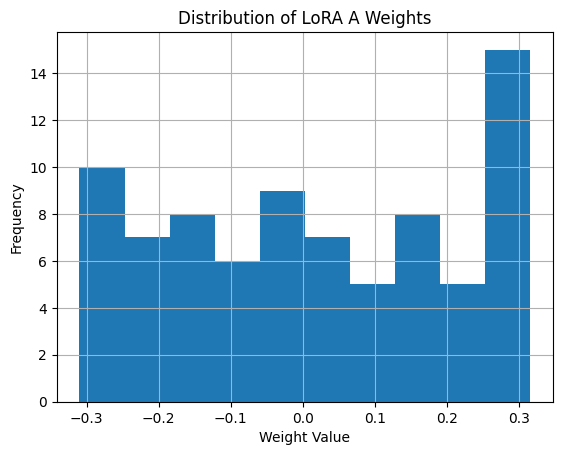

In [105]:
plt.hist(test_loraA, bins=10)
plt.title("Distribution of LoRA A Weights")
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

We change all the parameters in LoRA1 to 1, just like we have trained it.

In [106]:
for name, param in model_loaded.named_parameters():
    if name in ["base_model.model.0.lora_A.LoRA1.weight", "base_model.model.0.lora_B.LoRA1.weight"]:
        param.data = torch.ones_like(param)

In [107]:
test_loraA = ''
for name, param in model_loaded.named_parameters():
    if name == "base_model.model.0.lora_A.LoRA1.weight":
    # if name == "base_model.model.0.lora_B.LoRA1.weight":
        test_loraA = param.detach().cpu().numpy().flatten()
test_loraA

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

Now, when we do the propagation, we will have a different result.

In [108]:
model_loaded(torch.arange(0,10).view(1,10).float())

tensor([[ 618.5175, -475.0137]], grad_fn=<AddmmBackward0>)

### Swith to LoRA2

In [109]:
model_loaded

PeftModel(
  (base_model): LoraModel(
    (model): Sequential(
      (0): lora.Linear(
        (base_layer): Linear(in_features=10, out_features=10, bias=True)
        (lora_dropout): ModuleDict(
          (LoRA1): Identity()
        )
        (lora_A): ModuleDict(
          (LoRA1): Linear(in_features=10, out_features=8, bias=False)
        )
        (lora_B): ModuleDict(
          (LoRA1): Linear(in_features=8, out_features=10, bias=False)
        )
        (lora_embedding_A): ParameterDict()
        (lora_embedding_B): ParameterDict()
        (lora_magnitude_vector): ModuleDict()
      )
      (1): ReLU()
      (2): lora.Linear(
        (base_layer): Linear(in_features=10, out_features=2, bias=True)
        (lora_dropout): ModuleDict(
          (LoRA2): Identity()
        )
        (lora_A): ModuleDict(
          (LoRA2): Linear(in_features=10, out_features=8, bias=False)
        )
        (lora_B): ModuleDict(
          (LoRA2): Linear(in_features=8, out_features=2, bias=False)
   

In [111]:
model_loaded.set_adapter("LoRA2")

In [113]:
model_loaded.active_adapter

'LoRA2'

In [112]:
model_loaded(torch.arange(0,10).view(1,10).float())

tensor([[ 2.2643, -2.1980]], grad_fn=<AddBackward0>)

This value is the same as when I first do forward propagation with non-touched LoRA1. In other words, LoRA2 doesn't have any impact to the result either here as it is not trained.

## Disable adapters and have the output from original model

In [114]:
with model_loaded.disable_adapter():
    print(model_loaded(torch.arange(0,10).view(1,10).float()))

tensor([[ 2.2643, -2.1980]])
